In [3]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import sparse as sp
import pandas as pd

def preprocess_text_data(X_train, X_test, text_cols=None):
    """
    Transforma TODAS as colunas de texto em TF-IDF e concatena (com numéricos pass-through).
    Se text_cols=None, detecta automaticamente colunas de texto.
    Retorna: X_train_vec, X_test_vec, info (dict com vectorizers, text_cols, numeric_cols).
    """

    # 1) detectar colunas de texto se não foi passado
    if text_cols is None:
        text_cols = []
        for c in X_train.columns:
            s = X_train[c]
            if pd.api.types.is_string_dtype(s) or s.dtype == object:
                text_cols.append(c)
            elif pd.api.types.is_categorical_dtype(s):
                # categorias de strings contam como texto
                try:
                    if pd.api.types.is_object_dtype(s.cat.categories.dtype) or pd.api.types.is_string_dtype(s.cat.categories.dtype):
                        text_cols.append(c)
                except Exception:
                    pass

    # 2) vetorizar cada coluna de texto e empilhar
    vects_train = []
    vects_test  = []
    vectorizers = {}
    for col in text_cols:
        vec = TfidfVectorizer(
            strip_accents='unicode',
            lowercase=True,
            stop_words='english',
            token_pattern=r'(?u)\b\w\w+\b',
            ngram_range=(1, 2),
            min_df=10,
            max_df=0.98,
            max_features=40000,
            sublinear_tf=True,
            dtype=np.float32
        )
        
        Xtr_col = vec.fit_transform(X_train[col].astype(str).fillna(''))
        Xte_col = vec.transform(X_test[col].astype(str).fillna(''))
        vects_train.append(Xtr_col)
        vects_test.append(Xte_col)
        vectorizers[col] = vec

    # 3) passar numéricos (se houver)
    numeric_cols = [c for c in X_train.columns if c not in text_cols and pd.api.types.is_numeric_dtype(X_train[c])]
    if numeric_cols:
        Xtr_num = sp.csr_matrix(np.asarray(X_train[numeric_cols].fillna(0.0)))
        Xte_num = sp.csr_matrix(np.asarray(X_test[numeric_cols].fillna(0.0)))
        vects_train.append(Xtr_num)
        vects_test.append(Xte_num)

    # 4) hstack final
    X_train_vec = sp.hstack(vects_train).tocsr()
    X_test_vec  = sp.hstack(vects_test).tocsr()

    info = {"vectorizers": vectorizers, "text_cols": text_cols, "numeric_cols": numeric_cols}
    return X_train_vec, X_test_vec, info

In [4]:
import sklearn
from pathlib import Path
import shutil
import pandas as pd

# %% Configurações de dataset
DATASET_NAME = 'imdb'
RANDOM_STATE = 1

# %% Carregamento
df = pd.read_csv(f'../data/{DATASET_NAME}.csv')
df.columns = df.columns.str.lower()

X = df.drop(columns='sentiment')
y = df['sentiment']
label_map = {'negative': 0, 'positive': 1}
y = y.map(label_map).astype('int8')

# %% Split
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X, y, random_state=RANDOM_STATE, stratify=y, test_size=0.3
)

X_train, X_test, info = preprocess_text_data(X_train, X_test, text_cols=None)

# %% Diretórios temporários
TMP_ROOT = Path('../results/tmp') / DATASET_NAME
if TMP_ROOT.exists():
    shutil.rmtree(TMP_ROOT)

X_train.shape, X_test.shape, y_train.shape, y_test.shape, info

((35000, 40000),
 (15000, 40000),
 (35000,),
 (15000,),
 {'vectorizers': {'review': TfidfVectorizer(dtype=<class 'numpy.float32'>, max_df=0.98, max_features=40000,
                   min_df=10, ngram_range=(1, 2), stop_words='english',
                   strip_accents='unicode', sublinear_tf=True)},
  'text_cols': ['review'],
  'numeric_cols': []})

In [ ]:
from tpot import TPOTClassifier
from tpot import objectives
import time

def run_tpot(early_stop=20, max_time_mins=float('inf'), warm_start=False, search_space="linear"):
    scorer = sklearn.metrics.get_scorer('f1_weighted')

    tpot = TPOTClassifier(
        search_space=search_space,
        scorers=[scorer, objectives.complexity_scorer],
        scorers_weights=[1.0, -1.0],
        cv = 10,
        memory= str(TMP_ROOT / 'memory'),
        preprocessing= False,
        max_time_mins=max_time_mins,
        n_jobs=1,
        validation_strategy='split',
        early_stop=early_stop,
        warm_start=warm_start,
        periodic_checkpoint_folder= str(TMP_ROOT / 'checkpoints'),
        verbose=3,
        random_state=RANDOM_STATE
    )
    start = time.time()
    tpot.fit(X_train, y_train)
    return tpot, time.time() - start

/home/joao/miniconda3/envs/tpotenv/lib/python3.10/site-packages/stopit/__init__.py:10: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [6]:
import os
import sys
from datetime import datetime
from sklearn.base import clone

sys.path.insert(0, os.path.abspath(os.path.join('..', 'src')))

from metrics import evaluate_metrics
from serialize import serialize_tpot

def build_document(tpot, elapsed):
    """
    Gera um dicionário com métricas dos melhores modelos encontrados pelo TPOT.
    Mantém:
      - 'pareto_complexity': métricas do menor 'complexity_scorer' (desempate por maior 'f1_score')
      - 'pareto_f1': métricas do maior 'f1_score' (desempate por menor 'complexity_scorer')
      - 'best_model': métricas do tpot.fitted_pipeline_ 
    """

    individuals = tpot.evaluated_individuals
    individuals = individuals.drop(columns=individuals.select_dtypes(include="object").columns)
    individuals = individuals.drop(columns=["validation_f1_score", "validation_complexity_scorer", "validation_start_times", "validation_end_times"])
    individuals_dict = individuals.to_dict(orient='list')

    best_model = tpot.fitted_pipeline_
    model = serialize_tpot(best_model)
    metrics = evaluate_metrics(best_model, X_test, y_test)
    metrics['complexity_scorer'] = objectives.complexity_scorer(best_model, X_test, y_test)
    
    # Estrutura base do resultado
    result = {
        'timeStamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'time_spent': elapsed,
        'dataset': DATASET_NAME,
        'automl': 'tpot',
        'evaluated_individuals': individuals_dict,
        'models': {
            'fitted': model,
        },
        'metrics': {
            'fitted': metrics, 
        }   
    }
    
    # Verifica se existe Pareto front válido
    df = tpot.pareto_front
    if df is None or len(df) == 0:
        return result
    
    # Filtrar linhas válidas
    df_valid = df[
        df["Eval Error"].isna() &
        df["complexity_scorer"].notna() &
        df["f1_score"].notna() &
        df["Instance"].notna()
    ]
    
    if df_valid.empty:
        return result
    
    # Selecionar e treinar modelo de menor complexidade
    best_complexity = df_valid.sort_values(["complexity_scorer", "f1_score"], ascending=[True, False]).iloc[0]
    model = clone(best_complexity["Instance"])
    model.fit(X_train, y_train)
    result['models']['pareto_complexity'] = serialize_tpot(model)
    result['metrics']['pareto_complexity'] = evaluate_metrics(model, X_test, y_test)
    result['metrics']['pareto_complexity']['complexity_scorer'] = int(best_complexity["complexity_scorer"])
    
    # Selecionar e treinar modelo de maior F1
    best_f1 = df_valid.sort_values(["f1_score", "complexity_scorer"], ascending=[False, True]).iloc[0]
    model = clone(best_f1["Instance"])
    model.fit(X_train, y_train)
    result['models']['pareto_f1'] = serialize_tpot(model)
    result['metrics']['pareto_f1'] = evaluate_metrics(model, X_test, y_test)
    result['metrics']['pareto_f1']['complexity_scorer'] = int(best_f1["complexity_scorer"])
    
    return result, individuals

## Experimentos

In [ ]:
tpot, elapsed = run_tpot(early_stop=20)

Generation: : 0it [00:00, ?it/s]/home/joao/miniconda3/envs/tpotenv/lib/python3.10/site-packages/stopit/__init__.py:10: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [ ]:
document, individuals = build_document(tpot, elapsed)

/home/joao/miniconda3/envs/tpotenv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [ 0 32 39] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/joao/miniconda3/envs/tpotenv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [ ]:
document

{'timeStamp': '2025-08-11 12:47:13',
 'time_spent': 1305.21723985672,
 'dataset': 'digits',
 'automl': 'tpot',
 'evaluated_individuals': {'f1_score': [nan,
   nan,
   nan,
   nan,
   0.963603944486431,
   nan,
   nan,
   0.9551743372128014,
   0.8414587734186796,
   nan,
   nan,
   nan,
   0.9552192432026176,
   nan,
   0.8741207946841018,
   0.8602400434848845,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   0.9554756550968271,
   nan,
   0.9795038613069664,
   0.8898329138658905,
   0.36346929255394833,
   0.9463155014903378,
   0.9356132801631676,
   0.8543967205709301,
   0.6957547139651638,
   0.9608072523657698,
   0.8407665392154786,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   0.8241196093861667,
   nan,
   nan,
   0.45963331394602064,
   0.956142650777587,
   0.9469060743952873,
   nan,
   0.9588596629088334,
   nan,
   0.9665669260450542,
   0.9831971521916595,
   0.9795038613069664,
   0.8219057360020541,
   0.9554756550968271,
   0.9557517543400003,
   0.95

In [ ]:
individuals.head(5)

,f1_score,complexity_scorer,Generation,Submitted Timestamp,Completed Timestamp,Pareto_Front
0,NaN,NaN,0.0,1.754926e+09,1.754926e+09,NaN
1,NaN,NaN,0.0,1.754926e+09,1.754926e+09,NaN
2,NaN,NaN,0.0,1.754926e+09,1.754926e+09,NaN
3,NaN,NaN,0.0,1.754926e+09,1.754926e+09,NaN
4,0.963604,86163.0,0.0,1.754926e+09,1.754926e+09,NaN


In [ ]:
from mongo import mongo_insert

mongo_insert(document)

'689a1082912c5245bdc93821'

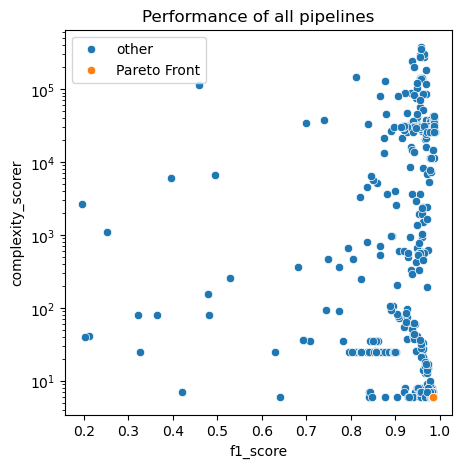

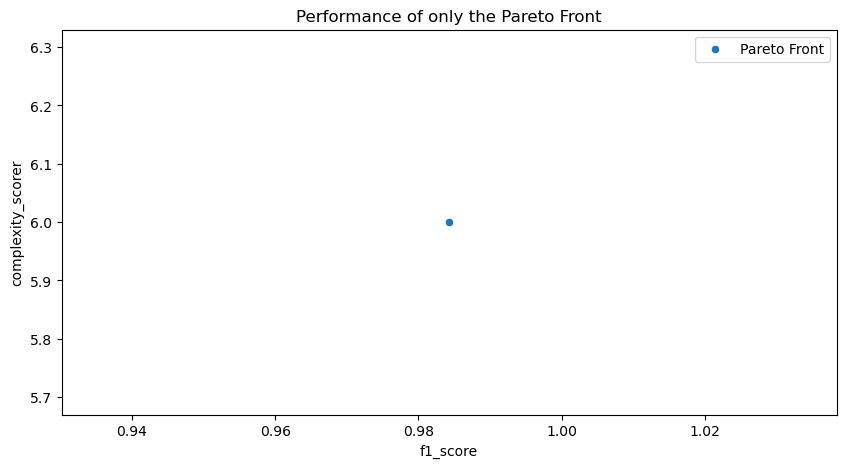

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

df = individuals
metric = 'f1_score'

fig, ax = plt.subplots(figsize=(5,5))
sns.scatterplot(df[df['Pareto_Front']!=1], x=metric, y='complexity_scorer', label='other', ax=ax)
sns.scatterplot(df[df['Pareto_Front']==1], x=metric, y='complexity_scorer', label='Pareto Front', ax=ax)
ax.title.set_text('Performance of all pipelines')
#log scale y
ax.set_yscale('log')
plt.show()

#replace nans in pareto front with 0
fig, ax = plt.subplots(figsize=(10,5))
sns.scatterplot(df[df['Pareto_Front']==1], x=metric, y='complexity_scorer', label='Pareto Front', ax=ax)
ax.title.set_text('Performance of only the Pareto Front')
#log scale y
# ax.set_yscale('log')
plt.show()

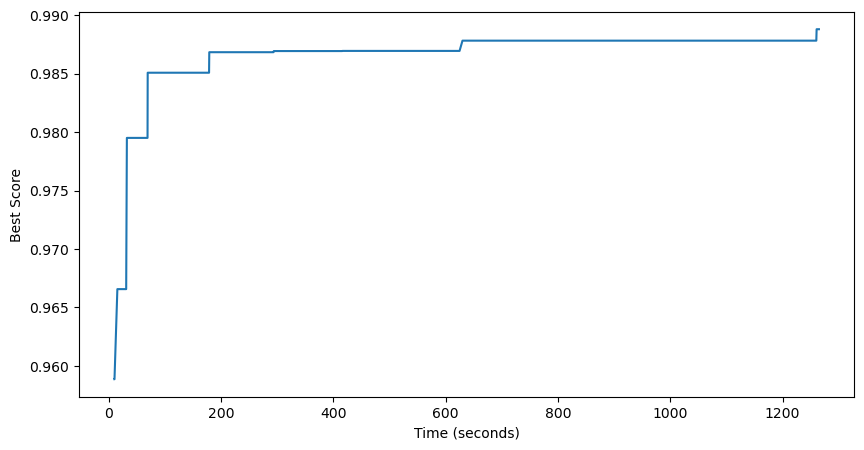

In [ ]:
import numpy as np

#get columns where roc_auc_score is not NaN
scores_and_times = df[df[metric].notna()][[metric, 'Completed Timestamp']].sort_values('Completed Timestamp', ascending=True).to_numpy()

#get best score at a given time
best_scores = np.maximum.accumulate(scores_and_times[:,0])
times = scores_and_times[:,1]
times = times - df['Submitted Timestamp'].min()

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(times, best_scores)
ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Best Score')
plt.show()


In [ ]:
tpot.fitted_pipeline_

,steps,"[('pipeline-1', ...), ('pipeline-2', ...)]"
,transform_input,None
,memory,None
,verbose,False
,steps,"[('impute_numeric', ...)]"
,transform_input,None
,memory,None
,verbose,False
,columns,'all'
,missing_values,nan
,strategy,'mean'


# datasets do vertex:

- Breast Cancer (Escolhido)

- Imdb

- Mnist